# Partitioning Schemes with PyMEOS and Pyspark

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.serializers import PickleSerializer
import pyspark.sql.functions as F

from pyspark.storagelevel import StorageLevel

from pysparkmeos.partitions.grid.grid_partitioner import GridPartition

from pysparkmeos.utils.udt_appender import udt_append
from pysparkmeos.UDF.udf import *
from pysparkmeos.partitions.mobilityrdd import MobilityRDD, MobilityPartitioner

import random, datetime

from datetime import timedelta
from functools import partial
from datetime import datetime, timezone
import contextily as cx
import distinctipy
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry as shp
from pymeos.plotters import (
    TemporalPointSequenceSetPlotter,
    TemporalPointSequencePlotter,
)

import matplotlib.pyplot as plt
import numpy as np
import os, sys
from shapely import wkb, box
import pandas as pd
from functools import reduce

from pymeos import TPoint, TPointInst, TPointSeq, TPointSeqSet
from typing import Iterator, List
import pandas as pd

pymeos_initialize()

In [2]:
def gentestdata(read_as='TInst'):
    testtrips = pd.read_csv("../../mobilitydb-berlinmod-sf0.1/trips_sample_pymeos.csv", index_col=0)
    testtrips['trip'] = testtrips['trip'].apply(lambda x: TGeomPointSeqSet(x))
    bounds = TemporalPointExtentAggregator().aggregate(testtrips['trip'])
    seqs1 = []
    seqs = []
    if read_as == 'TInst':
        seqs1 = [trip.instants() for trip in testtrips['trip']]
        for seq in seqs1:
            seqs.extend(seq)
        return seqs, bounds
    if read_as == 'TSeq':
        seqs1 = [trip.sequences() for trip in testtrips['trip']]
        for seq in seqs1:
            seqs.extend(seq)
        return seqs, bounds
    if read_as == 'TSeqSet':
        return list(testtrips['trip']), bounds

seqs, bounds = gentestdata(read_as='TSeq')
bounds

STBox(STBOX XT(((475982.1452146133,6583193.925816207),(495595.9328811999,6601525.43837019)),[2020-06-01 06:47:36.426576+00, 2020-06-11 14:58:24.149496+00)))

In [3]:
def new_bounds_from_axis(bounds, axis, p, to):
        b = p.bounding_box()
        if axis == 'x':
            if to == 'left':
                newbounds = STBox(
                    xmax=b.xmax(), xmin=bounds.xmin(), 
                    ymax=bounds.ymax(), ymin=bounds.ymin(), 
                    zmax=bounds.zmax(), zmin=bounds.zmin(), 
                    tmax=bounds.tmax(), tmin=bounds.tmin()
                )
            else:
                newbounds = STBox(
                    xmax=bounds.xmax(), xmin=b.xmin(), 
                    ymax=bounds.ymax(), ymin=bounds.ymin(), 
                    zmax=bounds.zmax(), zmin=bounds.zmin(), 
                    tmax=bounds.tmax(), tmin=bounds.tmin()
                )
        if axis == 'y':
            if to == 'left':
                newbounds = STBox(
                    xmax=bounds.xmax(), xmin=bounds.xmin(), 
                    ymax=b.ymax(), ymin=bounds.ymin(), 
                    zmax=bounds.zmax(), zmin=bounds.zmin(), 
                    tmax=bounds.tmax(), tmin=bounds.tmin()
                )
            else:
                newbounds = STBox(
                    xmax=bounds.xmax(), xmin=bounds.xmin(), 
                    ymax=bounds.ymax(), ymin=b.ymin(), 
                    zmax=bounds.zmax(), zmin=bounds.zmin(), 
                    tmax=bounds.tmax(), tmin=bounds.tmin()
                )
        if axis == 'z':
            if to == 'left':
                newbounds = STBox(
                    xmax=bounds.xmax(), xmin=bounds.xmin(), 
                    ymax=bounds.ymax(), ymin=bounds.ymin(), 
                    zmax=b.zmax(), zmin=bounds.zmin(), 
                    tmax=bounds.tmax(), tmin=bounds.tmin()
                )
            else:
                newbounds = STBox(
                    xmax=bounds.xmax(), xmin=bounds.xmin(), 
                    ymax=bounds.ymax(), ymin=bounds.ymin(), 
                    zmax=bounds.zmax(), zmin=b.zmin(), 
                    tmax=bounds.tmax(), tmin=bounds.tmin()
                )
        if axis == 't':
            if to == 'left':
                newbounds = STBox(
                    xmax=bounds.xmax(), xmin=bounds.xmin(), 
                    ymax=bounds.ymax(), ymin=bounds.ymin(), 
                    zmax=bounds.zmax(), zmin=bounds.zmin(), 
                    tmax=b.tmax(), tmin=bounds.tmin()
                )
            else:
                newbounds = STBox(
                    xmax=bounds.xmax(), xmin=bounds.xmin(), 
                    ymax=bounds.ymax(), ymin=bounds.ymin(), 
                    zmax=bounds.zmax(), zmin=bounds.zmin(), 
                    tmax=bounds.tmax(), tmin=b.tmin()
                )
        return newbounds

In [4]:
class KDTreePartition(MobilityPartitioner):      
    def __init__(self, depth: int, points: List[TPoint], bounds, dimensions: list, max_depth=12, ):
        self.depth = depth
        self.max_depth=max_depth
        self.bounds = bounds
        self.grid = self._generate_grid(bounds, points, depth, dimensions, max_depth)
        self.numPartitions = len(self.grid)
        self.gridstr = [tile.__str__() for tile in self.grid]
        # print(self.grid)
        
    def as_spark_table(self):
        gridstr = self.gridstr  # Do this so that spark doesn't break
        return GridSparkCreator(F.lit(gridstr))
    
    @staticmethod
    def _generate_grid(bounds, points: List[TPoint], depth: int, dimensions: list = ['x', 'y', 't'], max_depth=12):        
        axis = dimensions[depth % len(dimensions)]
        tiles = []

        # Find the points that are covered by the bounds
        convert = []
        pointsat = [point.at(bounds) for point in points]
        
        if type(pointsat[0]) == TGeomPointSeq:
            convert = [instant for point in pointsat for instant in point.instants()]
            points = convert
        if type(pointsat[0]) == TGeomPointSeqSet:
            convert = [
                instant 
                for seqset in pointsat 
                    for seq in seqset.sequences() 
                        for instant in seq.instants()
            ]
            points = convert
                
        def from_axis(p, axis):
            b = p
            if axis == 'x': return b.x().start_value()#(b.xmax() - b.xmin()) / 2
            if axis == 'y': return b.y().start_value()#(b.ymax() - b.ymin()) / 2
            if axis == 'z': return b.z().start_value()#(b.zmax() - b.zmin()) / 2
            if axis == 't': return b.timestamp()#(b.tmax() - b.tmin()) / 2
        
        # Sort the generator
        points = sorted(points, key=lambda p: from_axis(p, axis))

        total_instants = sum(p.num_instants() for p in points)
        num_points = sum(1 for _ in points)

        if depth == max_depth or num_points <= 1: 
            tiles.append(bounds)
        else:
            median = points[int(num_points / 2)]

            bboxleft = new_bounds_from_axis(bounds, axis, median, 'left')
            bboxright = new_bounds_from_axis(bounds, axis, median, 'right')

            #print("Median is ", median, " splitted by axis: ", axis)
                
            left = KDTreePartition._generate_grid(bboxleft, points[:int(num_points/2)], depth+1, dimensions, max_depth)
            right = KDTreePartition._generate_grid(bboxright, points[int(num_points/2):], depth+1, dimensions, max_depth)
            tiles.extend(left)
            tiles.extend(right)
        return tiles
        
    @staticmethod
    def get_partition(point: Any, grid: list, utc_time: str = "UTC", **kwargs) -> int:
        pymeos_initialize()
        if type(point) == str:
            point = TGeomPointInst(point)
        # Little tweak to avoid pymeos bug
        point = point.set_srid(0)
        point = STBox(point.bounding_box().__str__().strip("GEOD"))
        for idx, partition in enumerate(grid):
            stbox: STBox = STBox(partition)
            if point.is_contained_in(stbox):
                return idx
        return -1

    def num_partitions(self) -> int:
        return self.numPartitions


@F.udtf(returnType=StructType([
    StructField("tileid", IntegerType()),
    StructField("tile", STBoxUDT())
]))
class GridSparkCreator:
    def eval(self, gridstr):
        pymeos_initialize()
        for tileid, tile in enumerate(gridstr):
            yield tileid, STBox(tile)

In [5]:
testtrips, bounds = gentestdata(read_as='TSeqSet')
print(bounds)
kdpart = KDTreePartition(depth=0, points=testtrips, dimensions=['x', 'y'], bounds=bounds, max_depth=3)

STBOX XT(((475982.1452146133,6583193.925816207),(495595.9328811999,6601525.43837019)),[2020-06-01 06:47:36.426576+00, 2020-06-11 14:58:24.149496+00))


### Initialize PyMEOS and setup Spark

In [6]:
# Initialize PyMEOS
pymeos_initialize("UTC")

os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

#.config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("PySpark UDF Example with PyMEOS") \
    .master("local[3]") \
    .config("spark.default.parallelism", 3) \
    .config("spark.executor.memory", "3g") \
    .config("spark.executor.cores", 1) \
    .config("spark.driver.memory", "2g") \
    .config("spark.driver.maxResultSize", 0) \
    .config("spark.sql.allowMultipleTableArguments.enabled", True) \
    .getOrCreate()

#spark.sparkContext.setLogLevel("DEBUG")

# Append the UDT mapping to the PyMEOS classes
udt_append()

# Get the value of 'spark.default.parallelism'
print(spark.sparkContext.getConf().getAll())
#print(f"spark.default.parallelism: {default_parallelism}")
#print(f"spark.sql.allowMultipleTableArguments.enabled: {spark.sparkContext.getConf().get('spark.sql.allowMultipleTableArguments.enabled')}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/04 08:25:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


[('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'), ('spark.executor.memory', '3g'), ('spark.app.submitTime', '1717489508439'), ('spark.sql.allowMultipleTabl

24/06/04 08:25:22 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 52684)
Traceback (most recent call last):
  File "/usr/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.9/socketserver.py", line 720, in __init__
    self.handle()
  File "/usr/local/lib/python3.9/dist-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_

## Read the DataFrame and create the columns of Pymeos data objects

First, we are going to read a dataset from OpenSky, this dataset cointains the trajectory information of multiple flights within a timeframe.  

Using the latitude, longitude and timestamp we can create a PyMEOS TGeogPointInst, that in PySpark will be wrapped into a TGeogPointInstUDT object.

In [8]:
# Read data from a CSV file
#data_path = "../../small_small_states_2022-06-27-00.csv"  # Update this with your CSV file path
data_path = "../../sample.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True, mode='PERMISSIVE').select("icao24", "time", "lat", "lon")

# Clean nans, if not Points can't be created
df = df.dropna(subset=["lat", "lon", "time", "icao24"])

    #.withColumn("Point", F.concat(F.lit("Point("), F.col("lat"), F.lit(" "), F.col("lon"), F.lit(")@"), F.col("time"))) \
# Convert the 'time' column to the correct format
df = df \
    .withColumn("time", F.from_unixtime(F.col("time"), "yyyy-MM-dd' 'HH:mm:ss")) \
    .withColumn("lat", F.round("lat", 2)) \
    .withColumn("lon", F.round("lon", 2)) \
    .withColumn("Point", create_point_udf("lat", "lon", "time")) \
    .withColumn("x", get_point_x("Point")) \
    .withColumn("y", get_point_y("Point")) \
    .withColumn("t", get_point_timestamp("Point")) \
    .withColumn("id", F.monotonically_increasing_id())

#    .withColumn("x", get_point_x("Point")) \
#    .withColumn("y", get_point_y("Point")) \
#    .withColumn("t", get_point_timestamp("Point")) \
# df.createOrReplaceTempView("rawPoints")

df.tail(5)

#for row in df.toLocalIterator():
#    print(row)

[Row(icao24='a00529', time='2022-06-27 00:00:55', lat=-25.02, lon=120.0, Point=TGeomPointInstWrap(POINT(120 -25.02)@2022-06-27 00:00:55+00), x=120.0, y=-25.020000457763672, t=datetime.datetime(2022, 6, 27, 0, 0, 55), id=1),
 Row(icao24='a00529', time='2022-06-27 00:00:58', lat=80.0, lon=10.0, Point=TGeomPointInstWrap(POINT(10 80)@2022-06-27 00:00:58+00), x=10.0, y=80.0, t=datetime.datetime(2022, 6, 27, 0, 0, 58), id=2),
 Row(icao24='a00528', time='2022-06-27 00:00:10', lat=0.0, lon=-75.5, Point=TGeomPointInstWrap(POINT(-75.5 0)@2022-06-27 00:00:10+00), x=-75.5, y=0.0, t=datetime.datetime(2022, 6, 27, 0, 0, 10), id=3),
 Row(icao24='a00528', time='2022-06-27 00:00:20', lat=37.72, lon=-5.5, Point=TGeomPointInstWrap(POINT(-5.5 37.72)@2022-06-27 00:00:20+00), x=-5.5, y=37.720001220703125, t=datetime.datetime(2022, 6, 27, 0, 0, 20), id=4),
 Row(icao24='a00528', time='2022-06-27 00:00:30', lat=25.72, lon=12.5, Point=TGeomPointInstWrap(POINT(12.5 25.72)@2022-06-27 00:00:30+00), x=12.5, y=25.71

In [9]:
schema = StructType([
    StructField("icao24", StringType()),
    StructField("PointSeq", TGeomPointSeqUDT())
])

@F.udf(returnType=TGeomPointSeqUDT())
def pointSeqFromPoints(pointgroup):
    if not pointgroup:
        return None
    pymeos_initialize()
    if len(pointgroup) == 1:
        pointgroup = f'[{pointgroup[0].__str__()}]'
        return TGeomPointSeq(pointgroup)
    pointgroup = sorted(pointgroup, key=lambda x: x.timestamps()[0])
    pointseq = TGeomPointSeq(instant_list=pointgroup)
    return pointseq

print(df.count())

#df.select("Point").tail(5)
df.groupBy("icao24").agg(F.count("Point").alias("cnt")).orderBy("cnt",ascending=False).show()

trajectories = df.groupBy("icao24").agg(
    F.collect_list(F.col("Point")).alias("PointSeq")
).select("icao24", "PointSeq").withColumn("PointSeq", pointSeqFromPoints("PointSeq"))

print(trajectories.count())

trajectories.show(5)
#trajectories.collect()[0].PointSeq
#trajectories.rdd.getNumPartitions()

#spark.sparkContext.setCheckpointDir("./checkpoint")
#trajectories = trajectories.checkpoint()
#trajectories.tail(1).limit(1).collect()[0].PointSeq

6
+------+---+
|icao24|cnt|
+------+---+
|a00528|  3|
|a00529|  3|
+------+---+

2


+------+--------------------+
|icao24|            PointSeq|
+------+--------------------+
|a00528|[POINT(-75.5 0)@2...|
|a00529|[POINT(-81.5 28.7...|
+------+--------------------+



In [10]:
from pymeos import TPoint

@F.udf(returnType=STBoxUDT())
def point_to_stbox(tpoint: TPoint) -> STBox:
    pymeos_initialize()
    return tpoint.bounding_box()

trajectories = trajectories.withColumn("STBox", point_to_stbox("PointSeq")).withColumn("seqId", F.monotonically_increasing_id())
trajectories.createOrReplaceTempView("trajectories")
trajectories.show()
trajectories.cache()
print(trajectories.count())
#trajectories.rdd.getNumPartitions()

+------+--------------------+--------------------+-----+
|icao24|            PointSeq|               STBox|seqId|
+------+--------------------+--------------------+-----+
|a00528|[POINT(-75.5 0)@2...|STBOX XT(((-75.5,...|    0|
|a00529|[POINT(-81.5 28.7...|STBOX XT(((-81.5,...|    1|
+------+--------------------+--------------------+-----+



2


In [11]:
def bounds_calculate_map(partition_rows):
    pymeos_initialize("UTC")
    aggregator = TemporalPointExtentAggregator.start_aggregation()
    #print(iter(partition_rows))
    for row in partition_rows:
        if type(row) == Row:
            #print(row)
            seq = TGeomPointSeq(row.PointSeq.__str__())
            aggregator.add(seq)
    try:
        boundbox = STBoxWrap(aggregator.aggregation().__str__())
        return [(boundbox)]#[(boundbox)]
    except:
        return [(None)]


def bounds_calculate_reduce(bounds1, bounds2):
    pymeos_initialize("UTC")
    aggregation = None
    
    if bounds1 and bounds2:
        aggregation = bounds1 + bounds2
    elif not bounds1 and bounds2:
        aggregation = bounds2
    elif not bounds2:
        aggregation = bounds1

    if aggregation:
        boundbox = STBoxWrap(aggregation.__str__())
        return boundbox
    else:
        return None


bounds = trajectories.rdd.mapPartitions(bounds_calculate_map).reduce(bounds_calculate_reduce)
bounds

STBoxWrap(STBOX XT(((-81.5,-25.02),(120,80)),[2022-06-27 00:00:10+00, 2022-06-27 00:00:58+00)))

## Generate the partitioning scheme and repartition data

In [17]:
# We need to collect a sample of points, or all the points if they fit into memory
#pointsample = [traj.PointSeq for traj in trajectories.select('PointSeq').sample(0.05).collect()]
pointsample = [traj.PointSeq for traj in trajectories.select('PointSeq').collect()]

# Now we calculate the grid and partition accordingly
# Test only with x, y to visually observe the partitions, use x,y,t to test also with time dimension.
gp = KDTreePartition(depth=0, points=pointsample, dimensions=['x', 'y', 't'], bounds=bounds, max_depth=3)
grid = gp.as_spark_table()
grid.cache()
grid.show()
grid.createOrReplaceTempView("grid")
#grid.rdd.getNumPartitions()

+------+--------------------+
|tileid|                tile|
+------+--------------------+
|     0|STBOX XT(((-81.5,...|
|     1|STBOX XT(((-81.5,...|
|     2|STBOX XT(((-81.5,...|
|     3|STBOX XT(((10,-25...|
|     4|STBOX XT(((10,25....|
|     5|STBOX XT(((10,25....|
+------+--------------------+



In [18]:
%time
from pyspark.sql.types import Row
from typing import Iterator

schema = StructType([
    StructField("trajectoryId", StringType()),
    StructField("partitionKey", IntegerType()),
    StructField("trajectory", TGeomPointSeqUDT())
])

@F.udtf(returnType=schema)
class KDTreePartitionUDTF:
    def eval(self, row: Row):
        pymeos_initialize()
        sequence_id = row.seqId
        trajectory = row.trajectory
        #print(trajectory,type(trajectory))
        #print(row.grid[0])
        #grid = [STBoxWrap(f"SRID=4326;{tile.__str__().strip('SRID=4326;')}") for tile in row.grid]
        grid = row.grid
        gridids = row.gridids
        partitioned = [(key, trajectory.at(tile)) for key, tile in zip(gridids, grid)]
        #print(trajectory)
        #print(grid)
        #print(partitioned)
        count = 0
        responses = []
        for partition_key, partition_traj in partitioned:
            count += 1
            if partition_traj is None:
                continue
            else:
                #responses.append((sequence_id, partition_key, partition_traj,))
                seqs = partition_traj.segments()
                #print(seqs)
                for partition_traj_seq in seqs:
                    responses.append((sequence_id, partition_key, partition_traj_seq,))
        for response in responses:
            yield response


spark.udtf.register("KDTreePartitionUDTF", KDTreePartitionUDTF)

trajectoriesPartMap = spark.sql("""
    SELECT * 
    FROM KDTreePartitionUDTF(
        TABLE(
                SELECT 
                    seqId, 
                    PointSeq AS trajectory, 
                    (SELECT collect_list(tile) FROM grid) AS grid, 
                    (SELECT collect_list(tileid) FROM grid) AS gridids
                FROM trajectories
        )
    )
""")

num_partitions = gp.num_partitions()
#trajectoriesPartMap = trajectoriesPartMap.withColumn("trajectory", F.col("trajectory").cast("string"))
trajectoriesPartMap.printSchema()

#trajectoriesPartMap = trajectoriesPartMap.repartition(num_partitions, "partitionKey")

def map_partition_rdd(index, rows):
    for row in rows:
        yield (row['partitionKey'], row)

trajectoriesPartMapRdd = trajectoriesPartMap.rdd.mapPartitionsWithIndex(map_partition_rdd).partitionBy(num_partitions)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 15.3 µs


24/06/04 10:04:36 WARN SimpleTableFunctionRegistry: The function kdtreepartitionudtf replaced a previously registered function.


root
 |-- trajectoryId: string (nullable = true)
 |-- partitionKey: integer (nullable = true)
 |-- trajectory: pythonuserdefined (nullable = true)



In [19]:
%%time
from pyspark.sql import SQLContext

#trajectoriesPart = spark.table("trajectoriesPart")

#print(trajectoriesPart.tail(5))
#print(trajectoriesPart.count())
#print(trajectoriesPartMap.rdd.getNumPartitions())


# This operation can be costly, for testing do with few data points (<= 1000).
num_partitions = gp.num_partitions()
#trajectoriesPart = trajectoriesPart.repartition(num_partitions, "partitionKey")
#print(trajectoriesPart.rdd.getNumPartitions())
#trajectoriesPartRdd = trajectoriesPart.rdd.map(lambda x: (x['partitionKey'], x)).partitionBy(num_partitions)
trajectoriesPartMap = trajectoriesPartMapRdd.toDF(["partitionKey", "trajectorydata"]).withColumn("trajectory", F.col("trajectorydata.trajectory")).withColumn("trajectoryId", F.col("trajectorydata.trajectoryId")).drop("trajectorydata")
#trajectoriesPart.groupBy("trajectoryId").agg(F.count(F.col("trajectory")).alias("cnt")).orderBy("cnt", ascending=False).show()
trajectoriesPartMap.orderBy("trajectoryId").cache()
trajectoriesPartMap.show()

+------------+--------------------+-------------+
|partitionKey|          trajectory| trajectoryId|
+------------+--------------------+-------------+
|           0|[POINT(-75.5 0)@2...| 326417514496|
|           0|[POINT(-22.183464...| 326417514496|
|           0|[POINT(-81.5 28.7...|1005022347264|
|           1|[POINT(-22.183464...| 326417514496|
|           1|[POINT(-81.5 28.7...|1005022347264|
|           2|[POINT(-5.5 37.72...| 326417514496|
|           2|[POINT(10 80)@202...|1005022347264|
|           3|[POINT(12.5 25.72...| 326417514496|
|           3|[POINT(9.99999921...|1005022347264|
|           3|[POINT(120 -25.02...|1005022347264|
|           4|[POINT(9.9999998 ...| 326417514496|
|           4|[POINT(66.85394 2...|1005022347264|
+------------+--------------------+-------------+

CPU times: user 412 ms, sys: 39.4 ms, total: 451 ms
Wall time: 18.4 s


## Show the partition distribution

In [20]:
%%time

trajectoriesPartMap.groupBy("partitionKey").count().show()

#for idx, item in datardd.take(5):
#    print(idx, item)

trajectoriesPartRdd = trajectoriesPartMap.rdd
print(trajectoriesPartRdd.getNumPartitions())

# Function to count rows per partition
def count_in_partition(idx, iterator):
    cnt = 0
    for _ in iterator:
        cnt += 1
    return [(idx, cnt)]

# Using mapPartitionsWithIndex to count rows per partition
partition_counts = trajectoriesPartRdd.mapPartitionsWithIndex(count_in_partition).collect()
    
# Print the results
for partition_id, cnt in partition_counts:
    print(f"Partition {partition_id} has {cnt} rows")


trajectoriesPartMap.show()

+------------+-----+
|partitionKey|count|
+------------+-----+
|           0|    3|
|           1|    2|
|           2|    2|
|           3|    3|
|           4|    2|
+------------+-----+

6


Partition 0 has 3 rows
Partition 1 has 2 rows
Partition 2 has 2 rows
Partition 3 has 3 rows
Partition 4 has 2 rows
Partition 5 has 0 rows
+------------+--------------------+-------------+
|partitionKey|          trajectory| trajectoryId|
+------------+--------------------+-------------+
|           0|[POINT(-75.5 0)@2...| 326417514496|
|           0|[POINT(-22.183464...| 326417514496|
|           0|[POINT(-81.5 28.7...|1005022347264|
|           1|[POINT(-22.183464...| 326417514496|
|           1|[POINT(-81.5 28.7...|1005022347264|
|           2|[POINT(-5.5 37.72...| 326417514496|
|           2|[POINT(10 80)@202...|1005022347264|
|           3|[POINT(12.5 25.72...| 326417514496|
|           3|[POINT(9.99999921...|1005022347264|
|           3|[POINT(120 -25.02...|1005022347264|
|           4|[POINT(9.9999998 ...| 326417514496|
|           4|[POINT(66.85394 2...|1005022347264|
+------------+--------------------+-------------+

CPU times: user 123 ms, sys: 18.2 ms, total: 141 ms
Wall time

root
 |-- partitionKey: long (nullable = true)
 |-- trajectory: pythonuserdefined (nullable = true)
 |-- trajectoryId: string (nullable = true)



/tmp/ipykernel_15279/1069038169.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


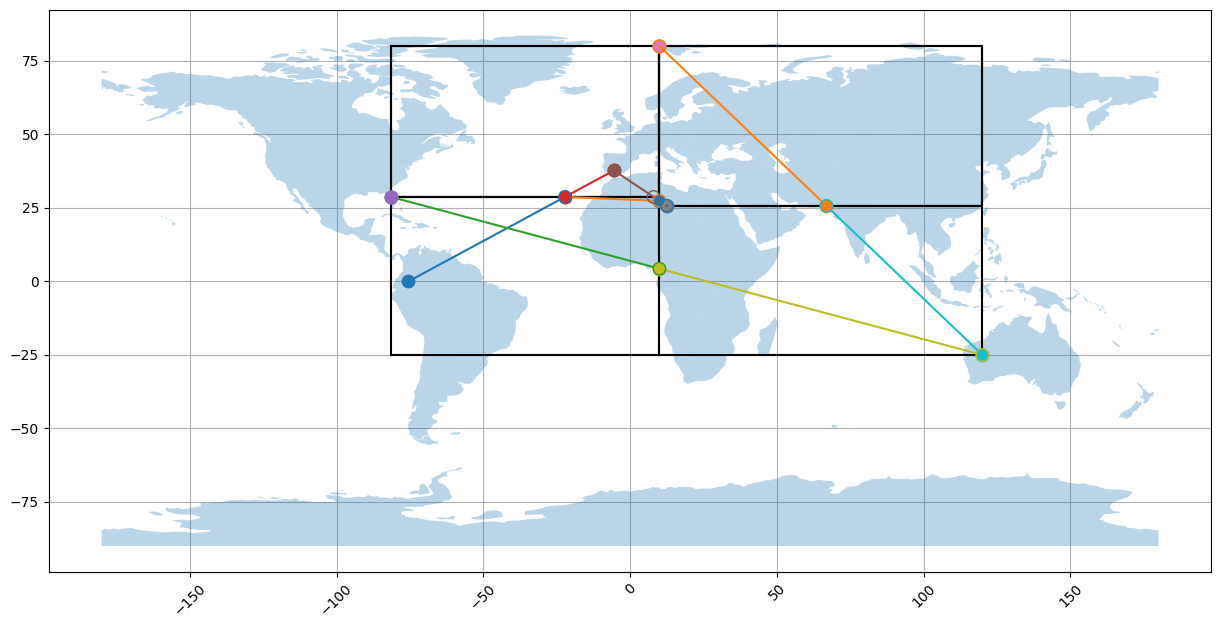

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# dfpoint = datardd.toDF(['partitionKey', 'Point'])
trajectoriesPartMap.printSchema()

# Create a bounding box
# bounding_box = box(bounds.xmin(), bounds.ymin(), bounds.xmax(), bounds.ymax())

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, alpha=0.3)
#print(grid)
gridstr = [row.tile.__str__() for row in grid.collect()]

colors = plt.cm.Accent(np.linspace(0, 1, len(gridstr)))
# Adding an alpha value when creating the color ma<p
alpha_value = 1.0
color_map = {i: colors[i][:3].tolist() + [alpha_value] for i, tile in enumerate(gridstr)}
for i, tilestr in enumerate(gridstr):
    tile: STBox = STBoxWrap(tilestr).set_srid(0)
    tile.plot_xy(axes=ax, color="black", draw_filling=False)

trajectory_colors = ['red', 'green', 'blue', 'yellow', 'orange', 'pink', 'lightgreen', 'darkblue']
trajectory_idx = {}

for idx, row in enumerate(trajectoriesPartMap.toLocalIterator()):
    #print(row.trajectoryId, row.partitionKey)
    if row.trajectoryId in trajectory_idx:
        c = trajectory_idx[row.trajectoryId]
    else:
        c = idx
        trajectory_idx[row.trajectoryId] = idx
    traj = row.trajectory
    #print(idx, row.partitionKey%gp.num_partitions())
    #print(traj)
    #if type(point)==str:
    #    point = TGeogPointInst(point)
    #tpointseq = point.to_sequence(interp).plot(axes=ax,label="tpoint", color=color_map[row.partitionKey % gp.num_partitions()], facecolors='none')
    #TemporalPointSequenceSetPlotter.plot_xy(
    #    traj, axes=ax, show_markers=True, show_grid=False
    #)
    TemporalPointSequencePlotter.plot_xy(
        traj, axes=ax, show_markers=True, show_grid=True 
    )
    #row.PointSeq.plot(axes=ax[0],label="trajectory", color=trajectory_colors[c%len(trajectory_colors)], show_markers=True)
